In [2]:
import numpy as np
from pytisean import tiseanio
from datasets import *
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
import pandas as pd
import os
print(os.getcwd())

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)

/home/varad/Dropbox/Data and Topology/code/d2-experiments


In [3]:
def moving_average(x, window = 4):
    
    s = pd.Series(x)
    s_ma = s.rolling(window, center=True).mean()

    return (np.array(s_ma)[int(window/2):-int(window/2)])

def plot_d2(d2,dims, filename, limits, start_dim=1):
    
    data_per_dim = int(d2.shape[0] / dims)
    plt.figure(figsize=(12,8), dpi=300)
    for dim in range(start_dim,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        
        plt.plot(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1], '.', 
                 #label=r'm=%d, d2=%.2f $\pm$ %.2f' % (dim, p[0], np.sqrt(COV[0][0])))
                 label=r'm=%d, d2=%.2f' % (dim, p[0]))
        
        #x_coord = np.arange(limits[0],limits[1],0.1)
        #y_coord = x_coord * p[0] + p[1]
        
        #plt.plot(x_coord, y_coord, color='black')
        plt.axvline(x=limits[0], color='black')
        plt.axvline(x=limits[1], color='black')
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'log ($\epsilon$)', fontsize=20)
    plt.ylabel(r'log (C($\epsilon$))', fontsize=20)    
    plt.legend(prop={'size': 16})
    plt.savefig(filename)
    print("Saving as ", filename)
    plt.show()
    
    
def fit_slopes(d2, dims, limits):
    data_per_dim = int(d2.shape[0] / dims)
    print(limits)
    for dim in range(1,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        print(r'embedding dim={}, correlation dimension={}+/-{}'.format(dim, p[0], np.sqrt(COV[0][0])))
        
        

# Lorenz Full

In [4]:
#n=500000
step_size=0.01
ds_rate = 1
n=100000
#timestep=0.05
noise_level = 0.0
#filter = 250
filter = 120

[t,data] = get_lorenz(n=n,timestep=step_size)
data_ma = np.zeros((data.shape[0] - filter, data.shape[1]))

for i in range(1):
    max_val = np.max((data[:,i])) - np.min((data[:,i]))
    print(max_val)
    data_ma[:,i] = moving_average(data[:,i] + noise_level*max_val*(np.random.random((data.shape[0])) - .5), 
                               window=filter)

data_ma[:,1] = data[:data_ma.shape[0],1]
data_ma[:,2] = data[:data_ma.shape[0],2]

lorenzTS = data_ma[:,0]
print(lorenzTS.shape)

#max_val = [np.max((data[:,i])) - np.min((data[:,i])) for i in range(3)]
#print(max_val)

(100000, 3)
37.67964806925325
(89880,)


Additional non-data files were created
/home/varad/Dropbox/Data and Topology/code/d2-experiments
Saving as  d2_figures_paper/lorenz_full_filtering_120_limits_-1.5_1.png


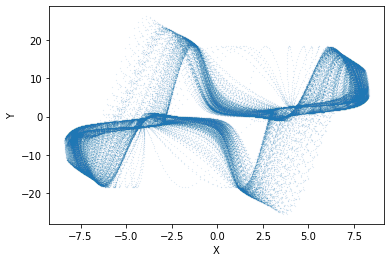

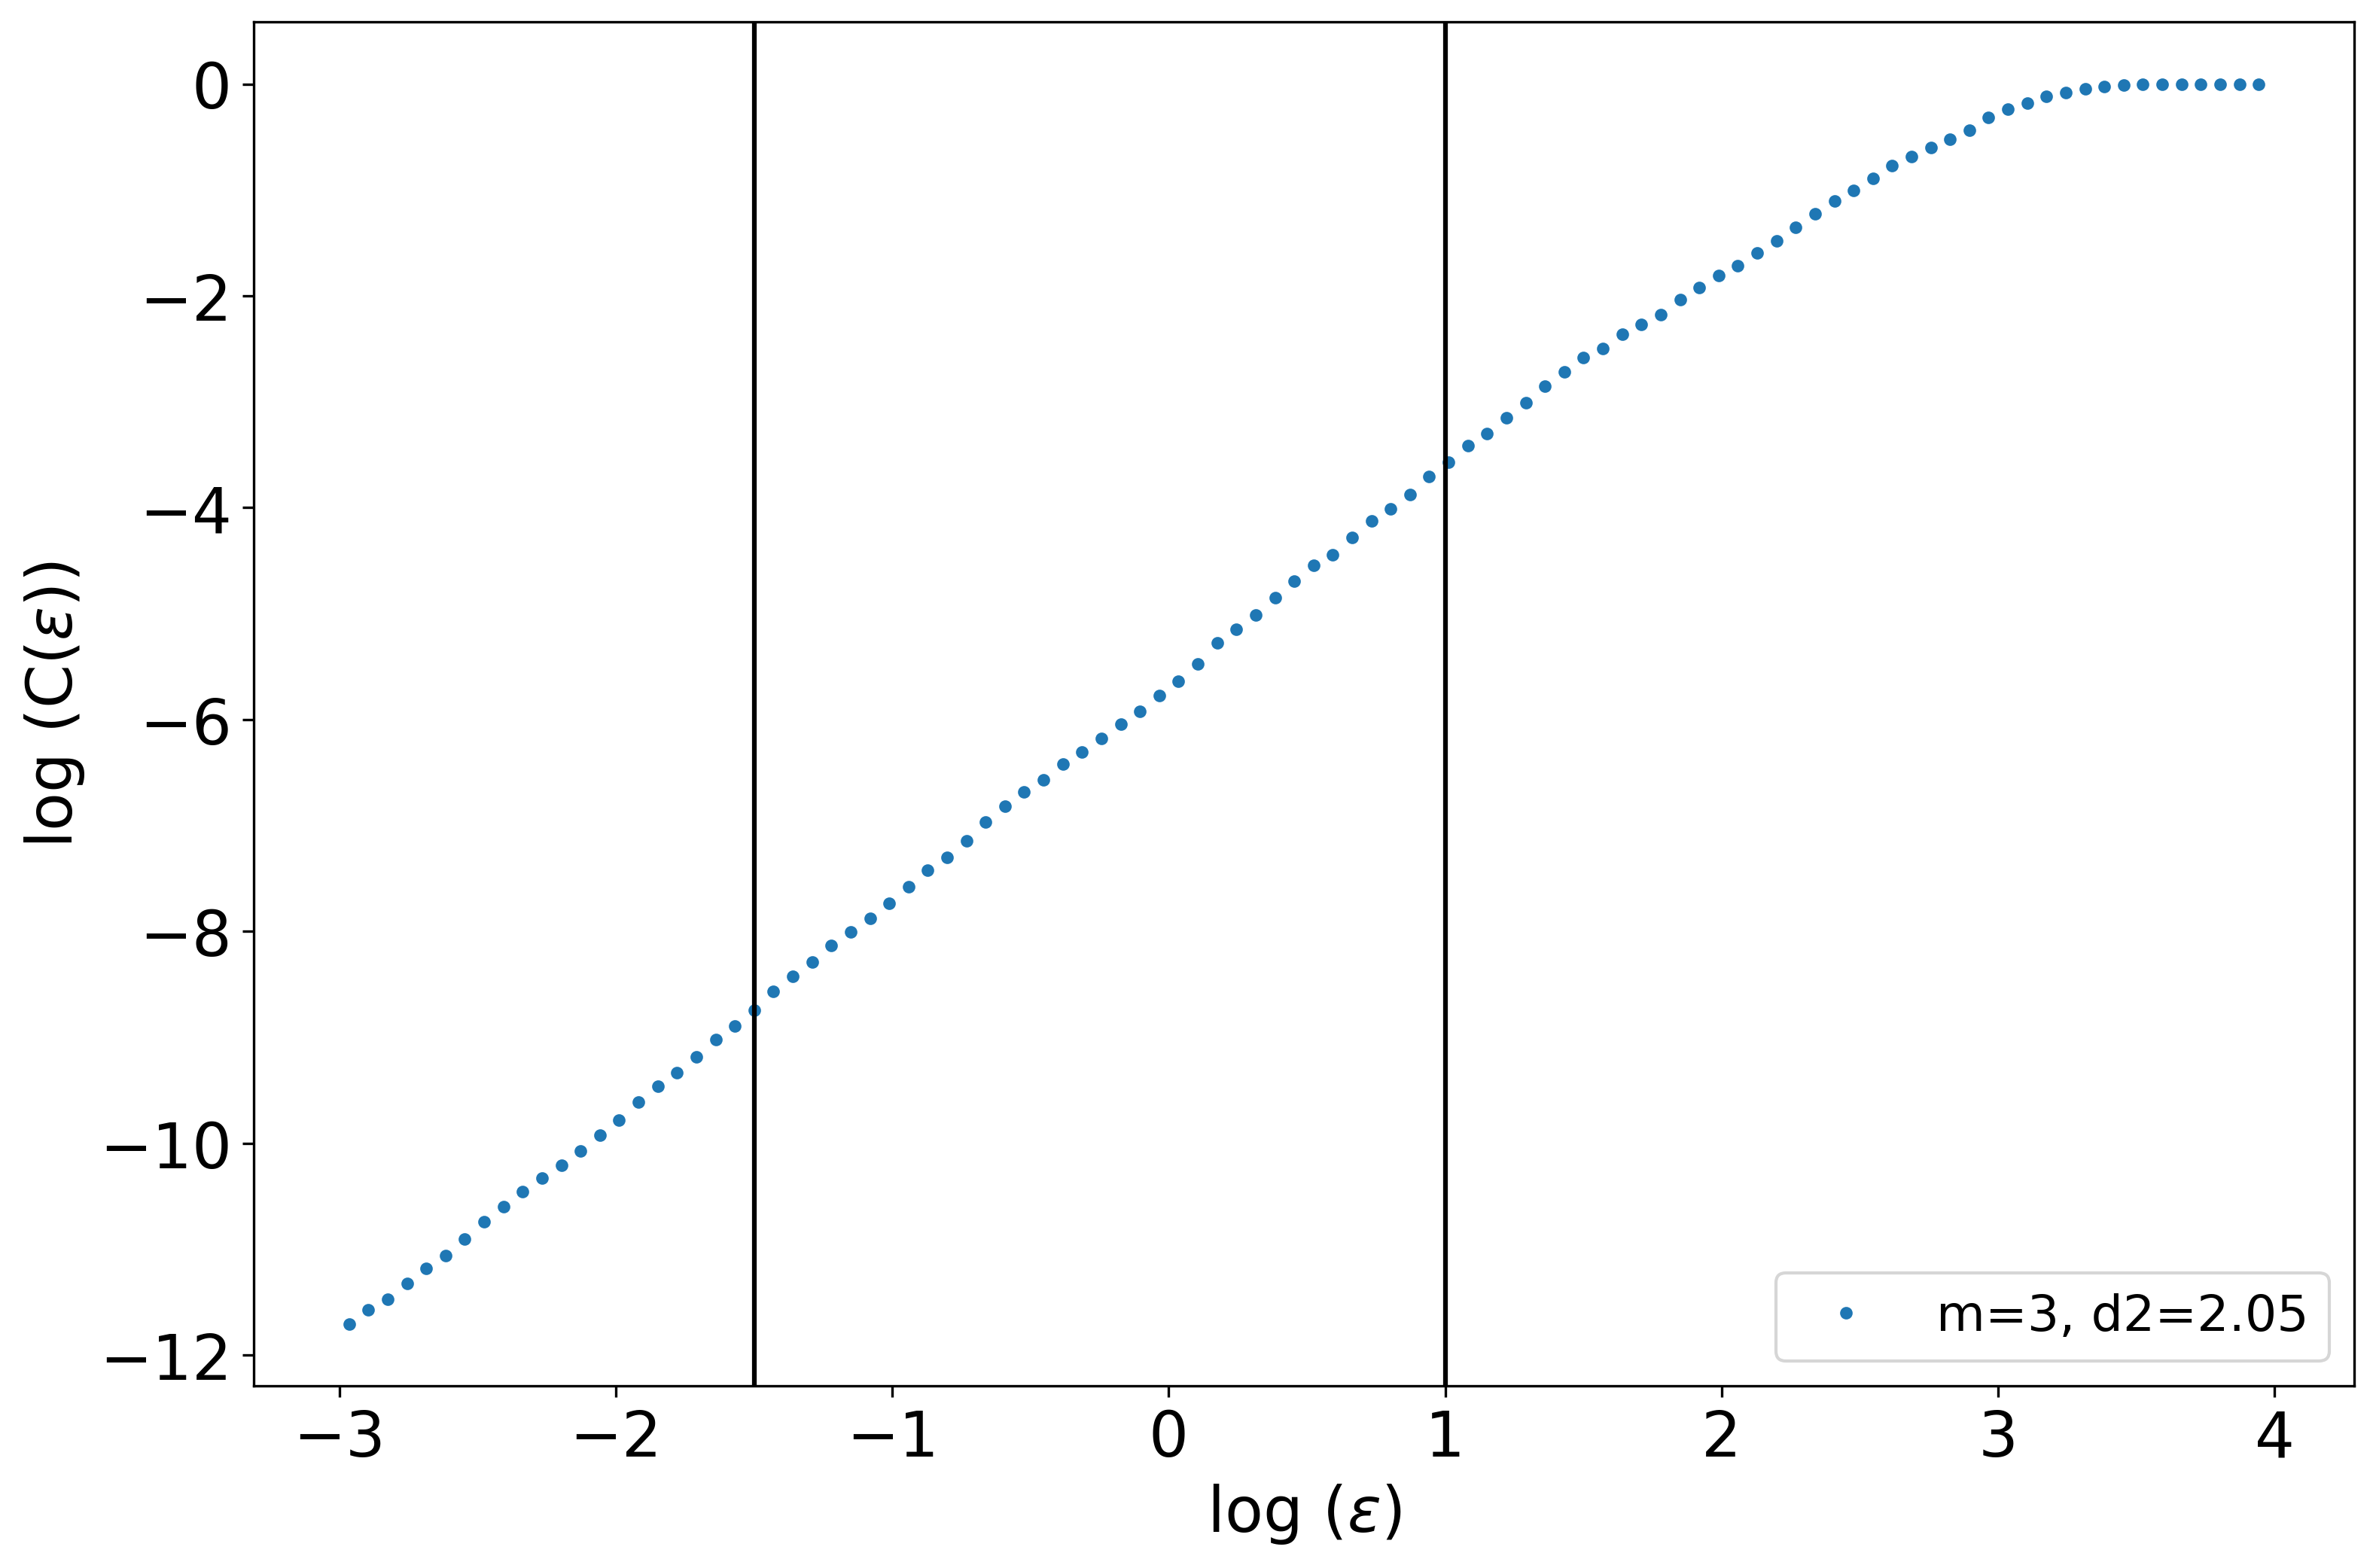

[-1.5, 1]
embedding dim=1, correlation dimension=0.9972419217636925+/-0.0022942082294438323
embedding dim=2, correlation dimension=1.6794194488063745+/-0.01100546667716556
embedding dim=3, correlation dimension=2.0455991852955733+/-0.0063205700944063215


In [5]:
limits=[-1.5,1]
dims = 3
plt.plot(data_ma[:,0],data_ma[:,1],'.',markersize=.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('lorenz_projection_noise_{}.png'.format(noise_level))

theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
corr = tiseanio('d2','-M','3,1','-c','1,2,3', '-t', theiler_window, data=data, silent=True)

c2 = corr[0]['c2']
#log_c2 = np.concatenate((np.log(c2[:,0]).reshape(-1,1), np.log(c2[:,1]).reshape(-1,1)), axis=1)
log_c2 = np.log(c2)
print(os.getcwd())
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_full_filtering_{}_limits_{}_{}.png'.format(filter, limits[0], limits[1]), limits, start_dim=3)
fit_slopes(log_c2, dims, limits)

In [6]:
tau_max = 150

'''
menger_mean = []
menger_variance = []
for tau in range(1,1000):
    menger = get_menger_centered_avg_embed(embed, 1, 0)
    menger_mean.append(np.mean(menger))
    menger_variance.append(np.var(menger))
'''
def get_menger_tau(data, tau_max):
    menger = [];
    dim = 2
    tau_avg = 1
    n_neighbors = 0
    menger_params = np.array([data.shape[0], 2, tau_max, tau_avg, n_neighbors])
    np.savetxt('menger_params.txt', menger_params)
    np.savetxt('menger_in.txt', data);
    np.savetxt('menger_params.txt', menger_params, fmt="%d")
    
    call(["./menger", "menger_in.txt", "menger_out.txt", "menger_params.txt"])
    menger_data = np.loadtxt("menger_out.txt");
    return menger_data[:,0], menger_data[:,1]

mutual_ma, err = tiseanio('mutual', '-D', tau_max, data=lorenzTS)
mutual, err = tiseanio('mutual', '-D', tau_max, data=lorenzTS)
#embed, err = tiseanio('delay', '-m', 2, '-d', tau, data=lorenzTS, silent=True)

[menger_mean, menger_var] = get_menger_tau(lorenzTS, tau_max)


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-04-12-20-50-24__qi457c4/inFile as datafile, reading column 1
Use 89880 lines.
Opened /tmp/pytisean_temp_2020-04-12-20-50-24__qi457c4/outFile for writing


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-04-12-20-50-24_y0hecikj/inFile as datafile, reading column 1
Use 89880 lines.
Opened /tmp/pytisean_temp_2020-04-12-20-50-24_y0hecikj/outFile for writing



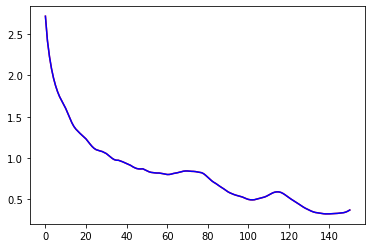

In [7]:
tau=18
plt.figure()
plt.plot(mutual[:,0], mutual[:,1], 'r')
plt.plot(mutual_ma[:,0], mutual_ma[:,1], 'b')
plt.show()

No handles with labels found to put in legend.


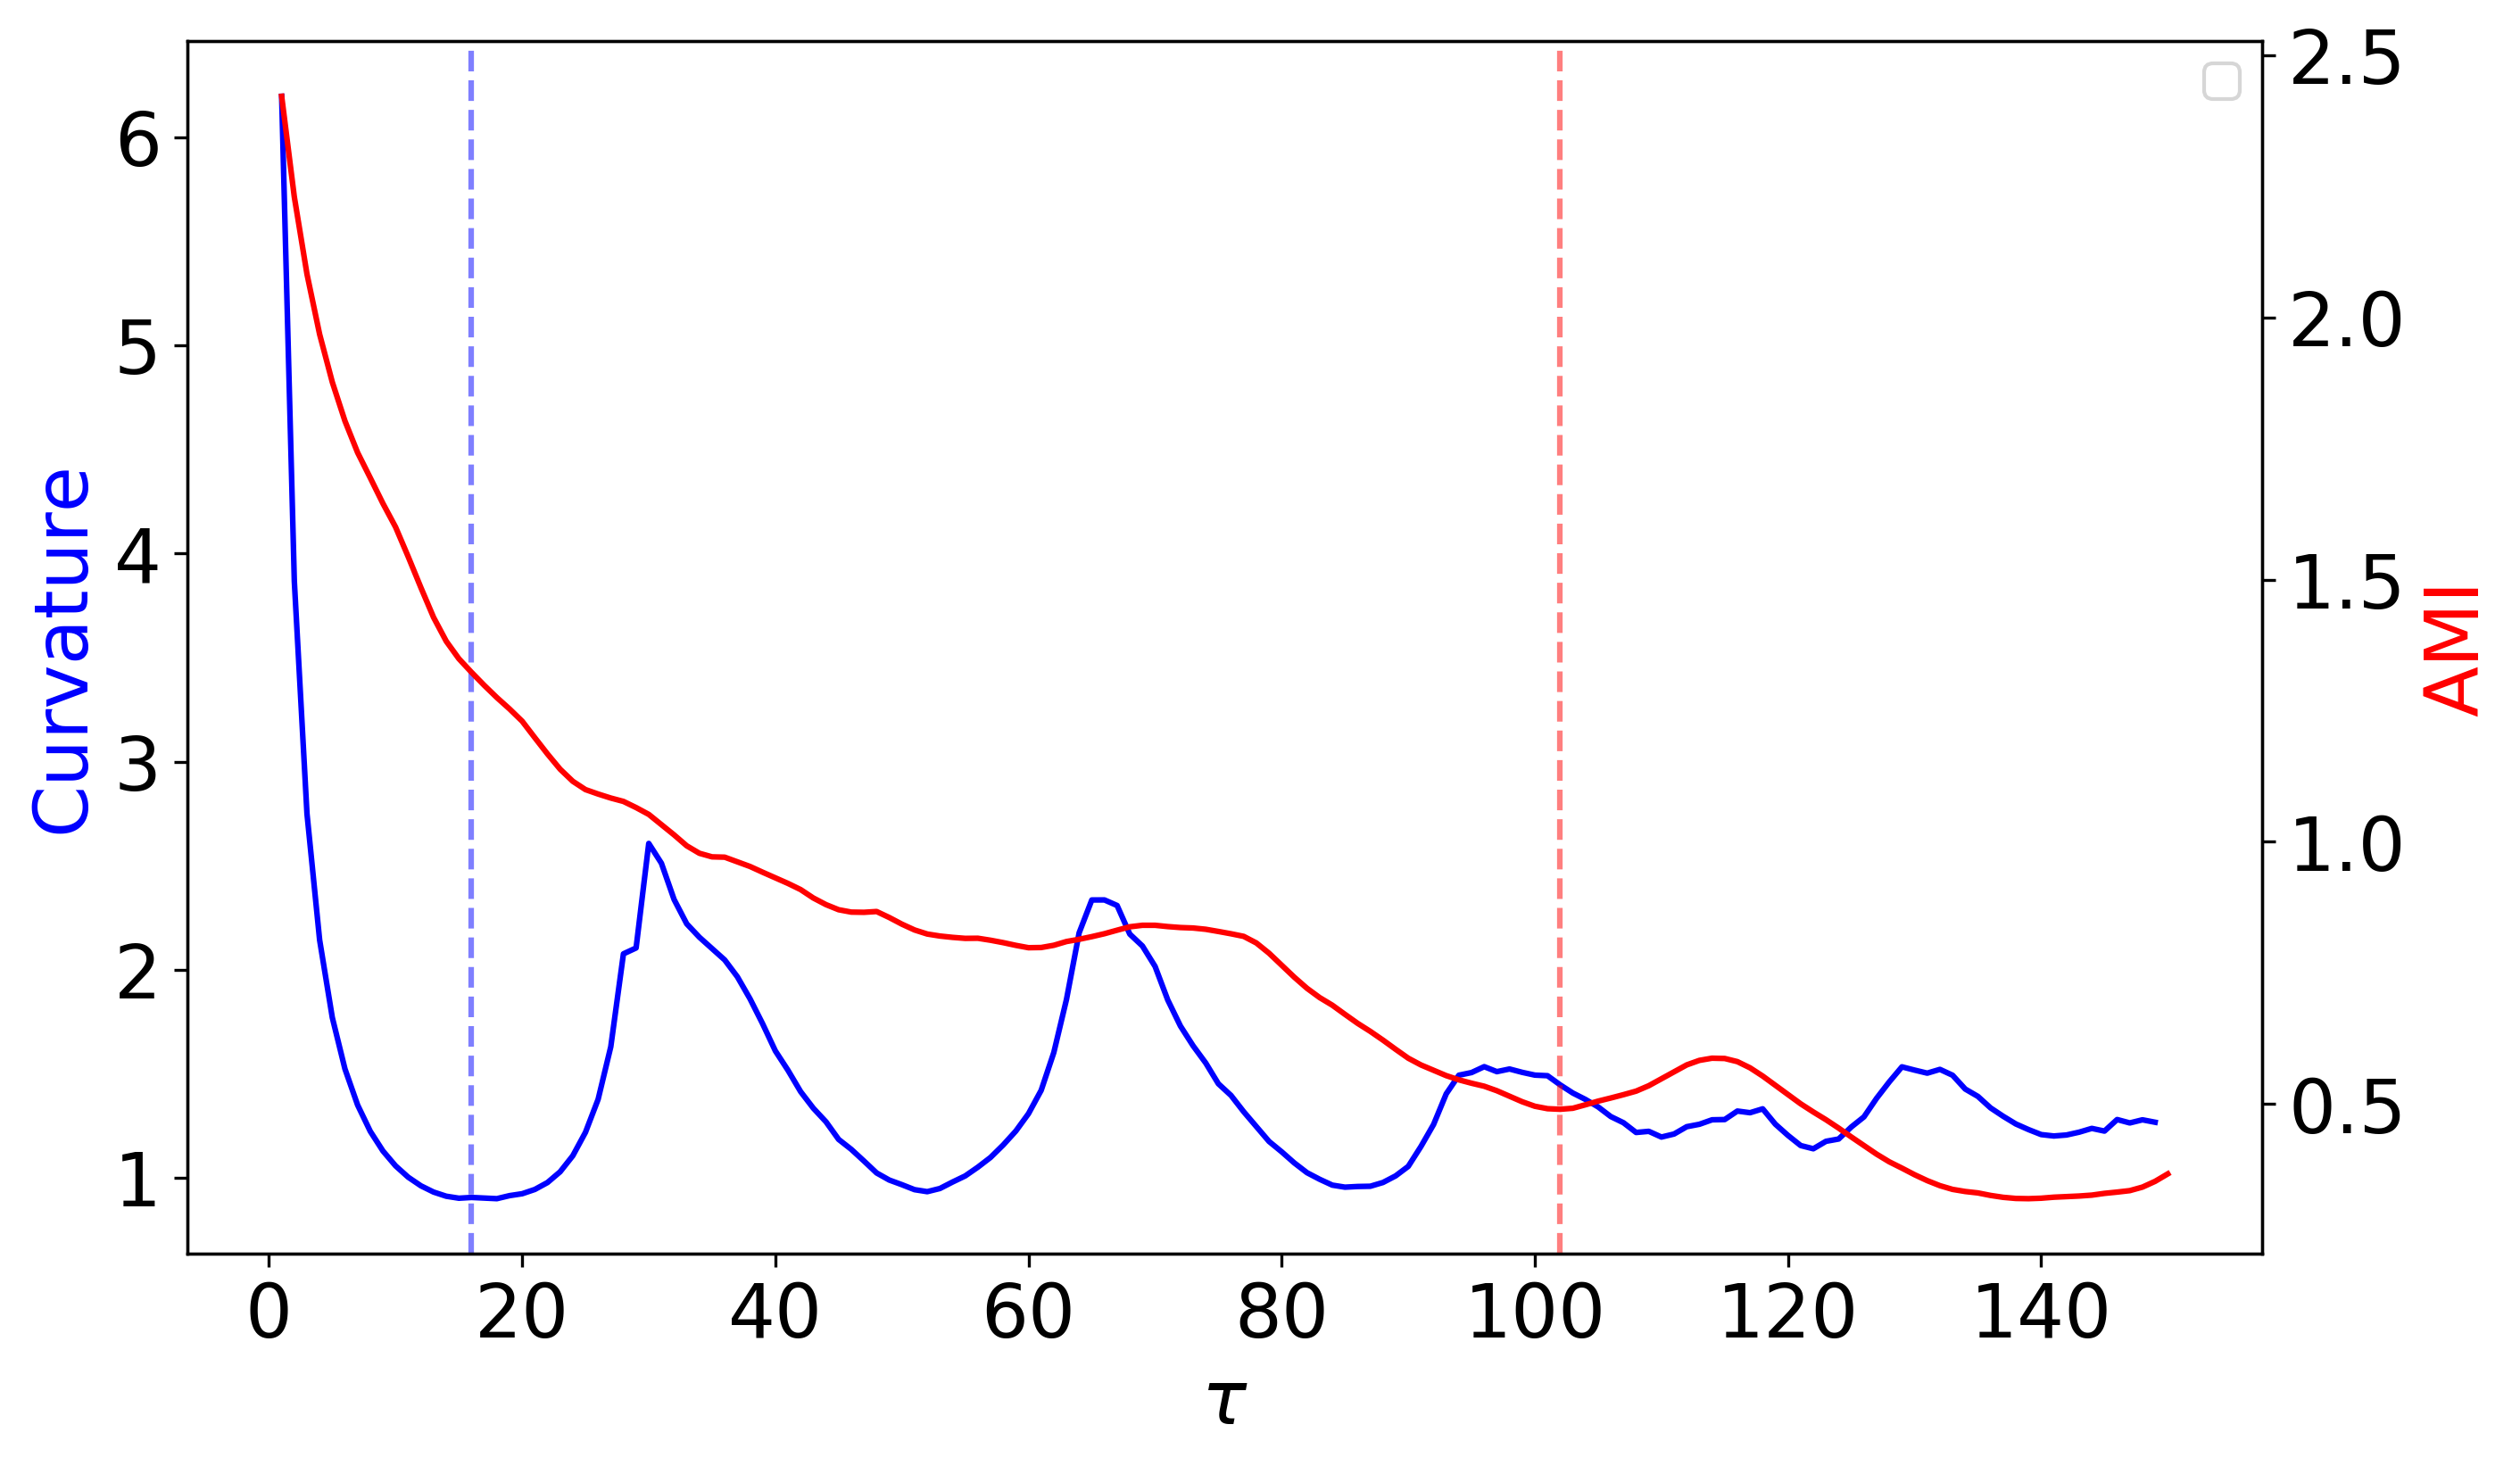

In [8]:
tau = 60
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
ax1.plot(np.arange(1,tau_max), menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(mutual[1:,0], mutual[1:,1], color = 'r')
ax2.set_ylabel(r'AMI', color='r', fontsize=20)
ax1.axvline(x = 16, color='b', linestyle='--', alpha=0.5)
ax2.axvline(x = 102, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/lorenz_measures_vs_tau_filtering_{}.png'.format(filter))#
#plt.savefig('lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))

No handles with labels found to put in legend.



TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

corr: Estimates the autocorrelations of a data set

Using /tmp/pytisean_temp_2020-04-14-22-22-02_0_zfsq8f/inFile as datafile, reading column 1
Use 89880 lines.
Opened /tmp/pytisean_temp_2020-04-14-22-22-02_0_zfsq8f/outFile for writing



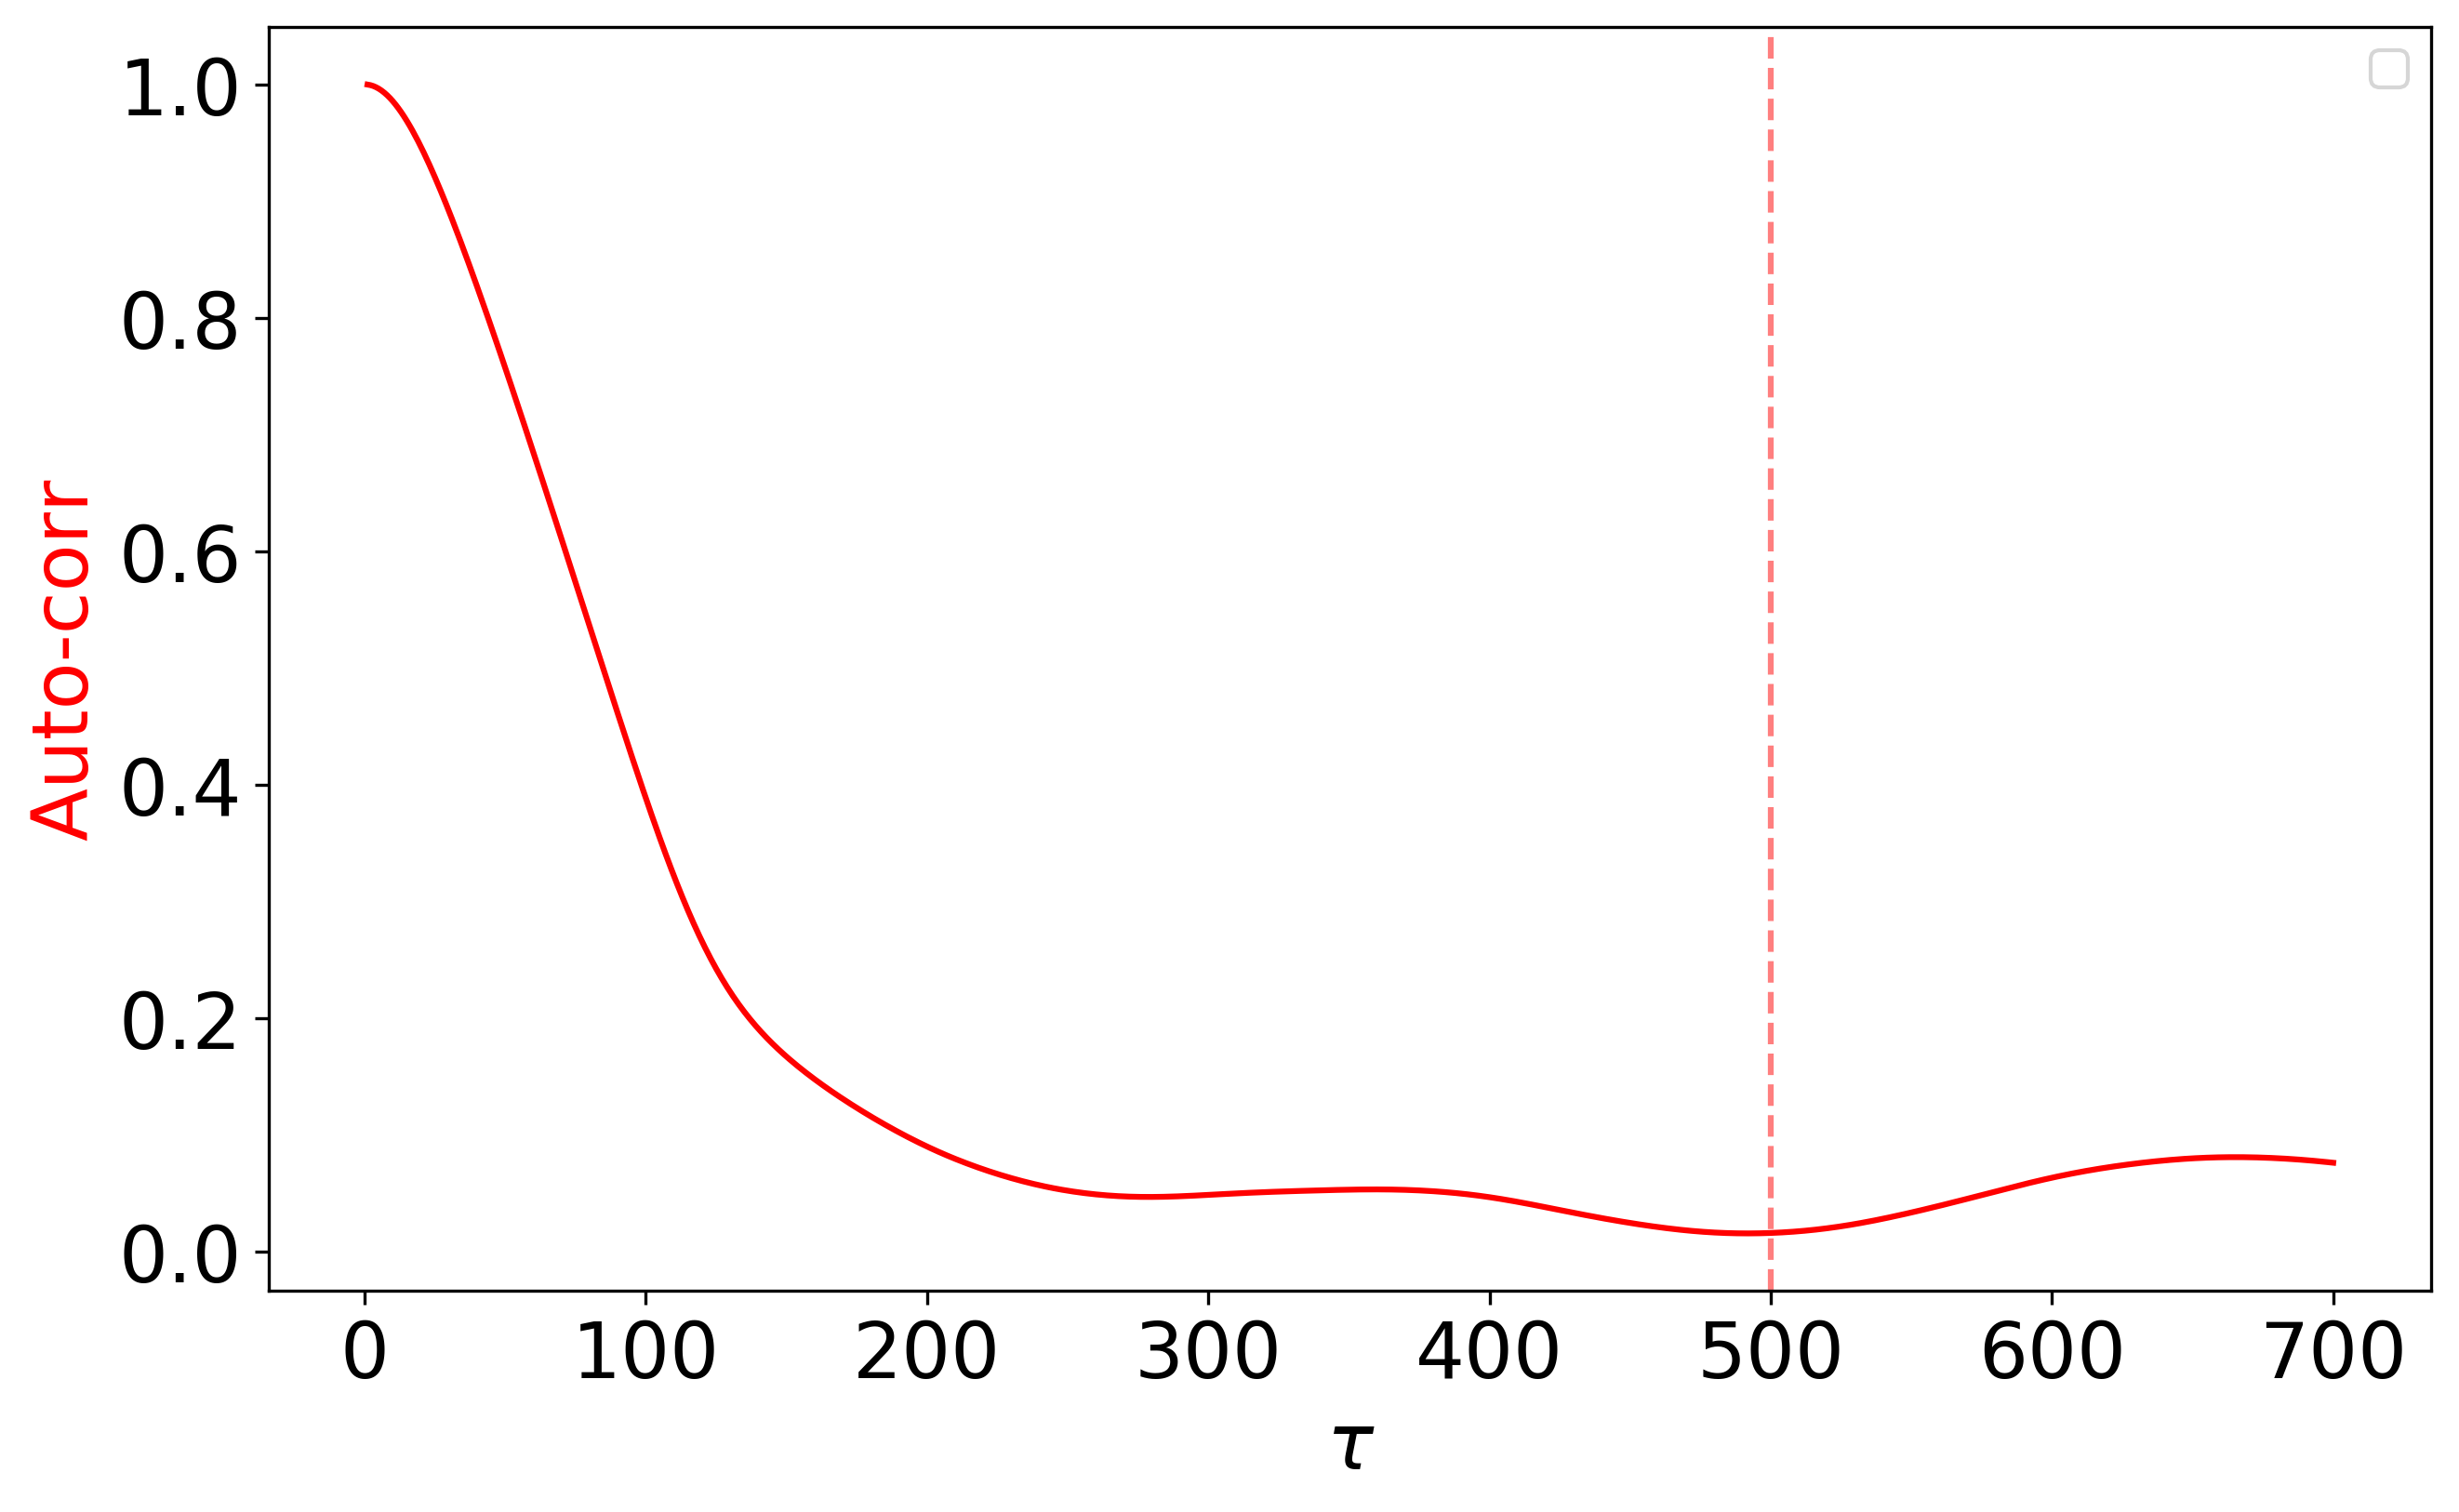

In [17]:
corr_ma, err = tiseanio('corr', '-D', 700, data=lorenzTS)
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
#ax1.plot(np.arange(1,tau_max), menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
#ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
#ax2 = ax1.twinx()
ax1.plot(corr_ma[1:,0], corr_ma[1:,1], color = 'r')
ax1.set_ylabel(r'Auto-corr', color='r', fontsize=20)
#ax1.axvline(x = 16, color='b', linestyle='--', alpha=0.5)
ax1.axvline(x = 500, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/corr/lorenz_measures_vs_tau_filtering_{}.png'.format(filter))#
#plt.savefig('lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))

In [104]:
print(menger_mean[:40])
print(mutual[90:120])

[6.19715  3.86714  2.74975  2.14227  1.77013  1.52298  1.34955  1.22318
 1.12873  1.05708  1.00249  0.961303 0.931245 0.91123  0.901662 0.905275
 0.902196 0.899452 0.914002 0.923189 0.943779 0.976952 1.02875  1.10577
 1.21823  1.37691  1.62943  2.07607  2.10432  2.60667  2.51151  2.3374
 2.2203   2.15583  2.10123  2.04677  1.96583  1.85995  1.7394   1.60977 ]
[[ 90.          0.587436 ]
 [ 91.          0.5745889]
 [ 92.          0.5644717]
 [ 93.          0.5541864]
 [ 94.          0.5461846]
 [ 95.          0.539723 ]
 [ 96.          0.5340066]
 [ 97.          0.52542  ]
 [ 98.          0.514939 ]
 [ 99.          0.5044456]
 [100.          0.4958329]
 [101.          0.4911864]
 [102.          0.4900816]
 [103.          0.4919947]
 [104.          0.4986466]
 [105.          0.505575 ]
 [106.          0.5115755]
 [107.          0.517888 ]
 [108.          0.5246629]
 [109.          0.534984 ]
 [110.          0.5481463]
 [111.          0.5614887]
 [112.          0.5746797]
 [113.          0

# Lorenz tau = 18 (Curvature)

22
Additional non-data files were created
Saving as  d2_figures_paper/lorenz_curvature_tau_16_filtering_250_limits_-4_-1.5.png


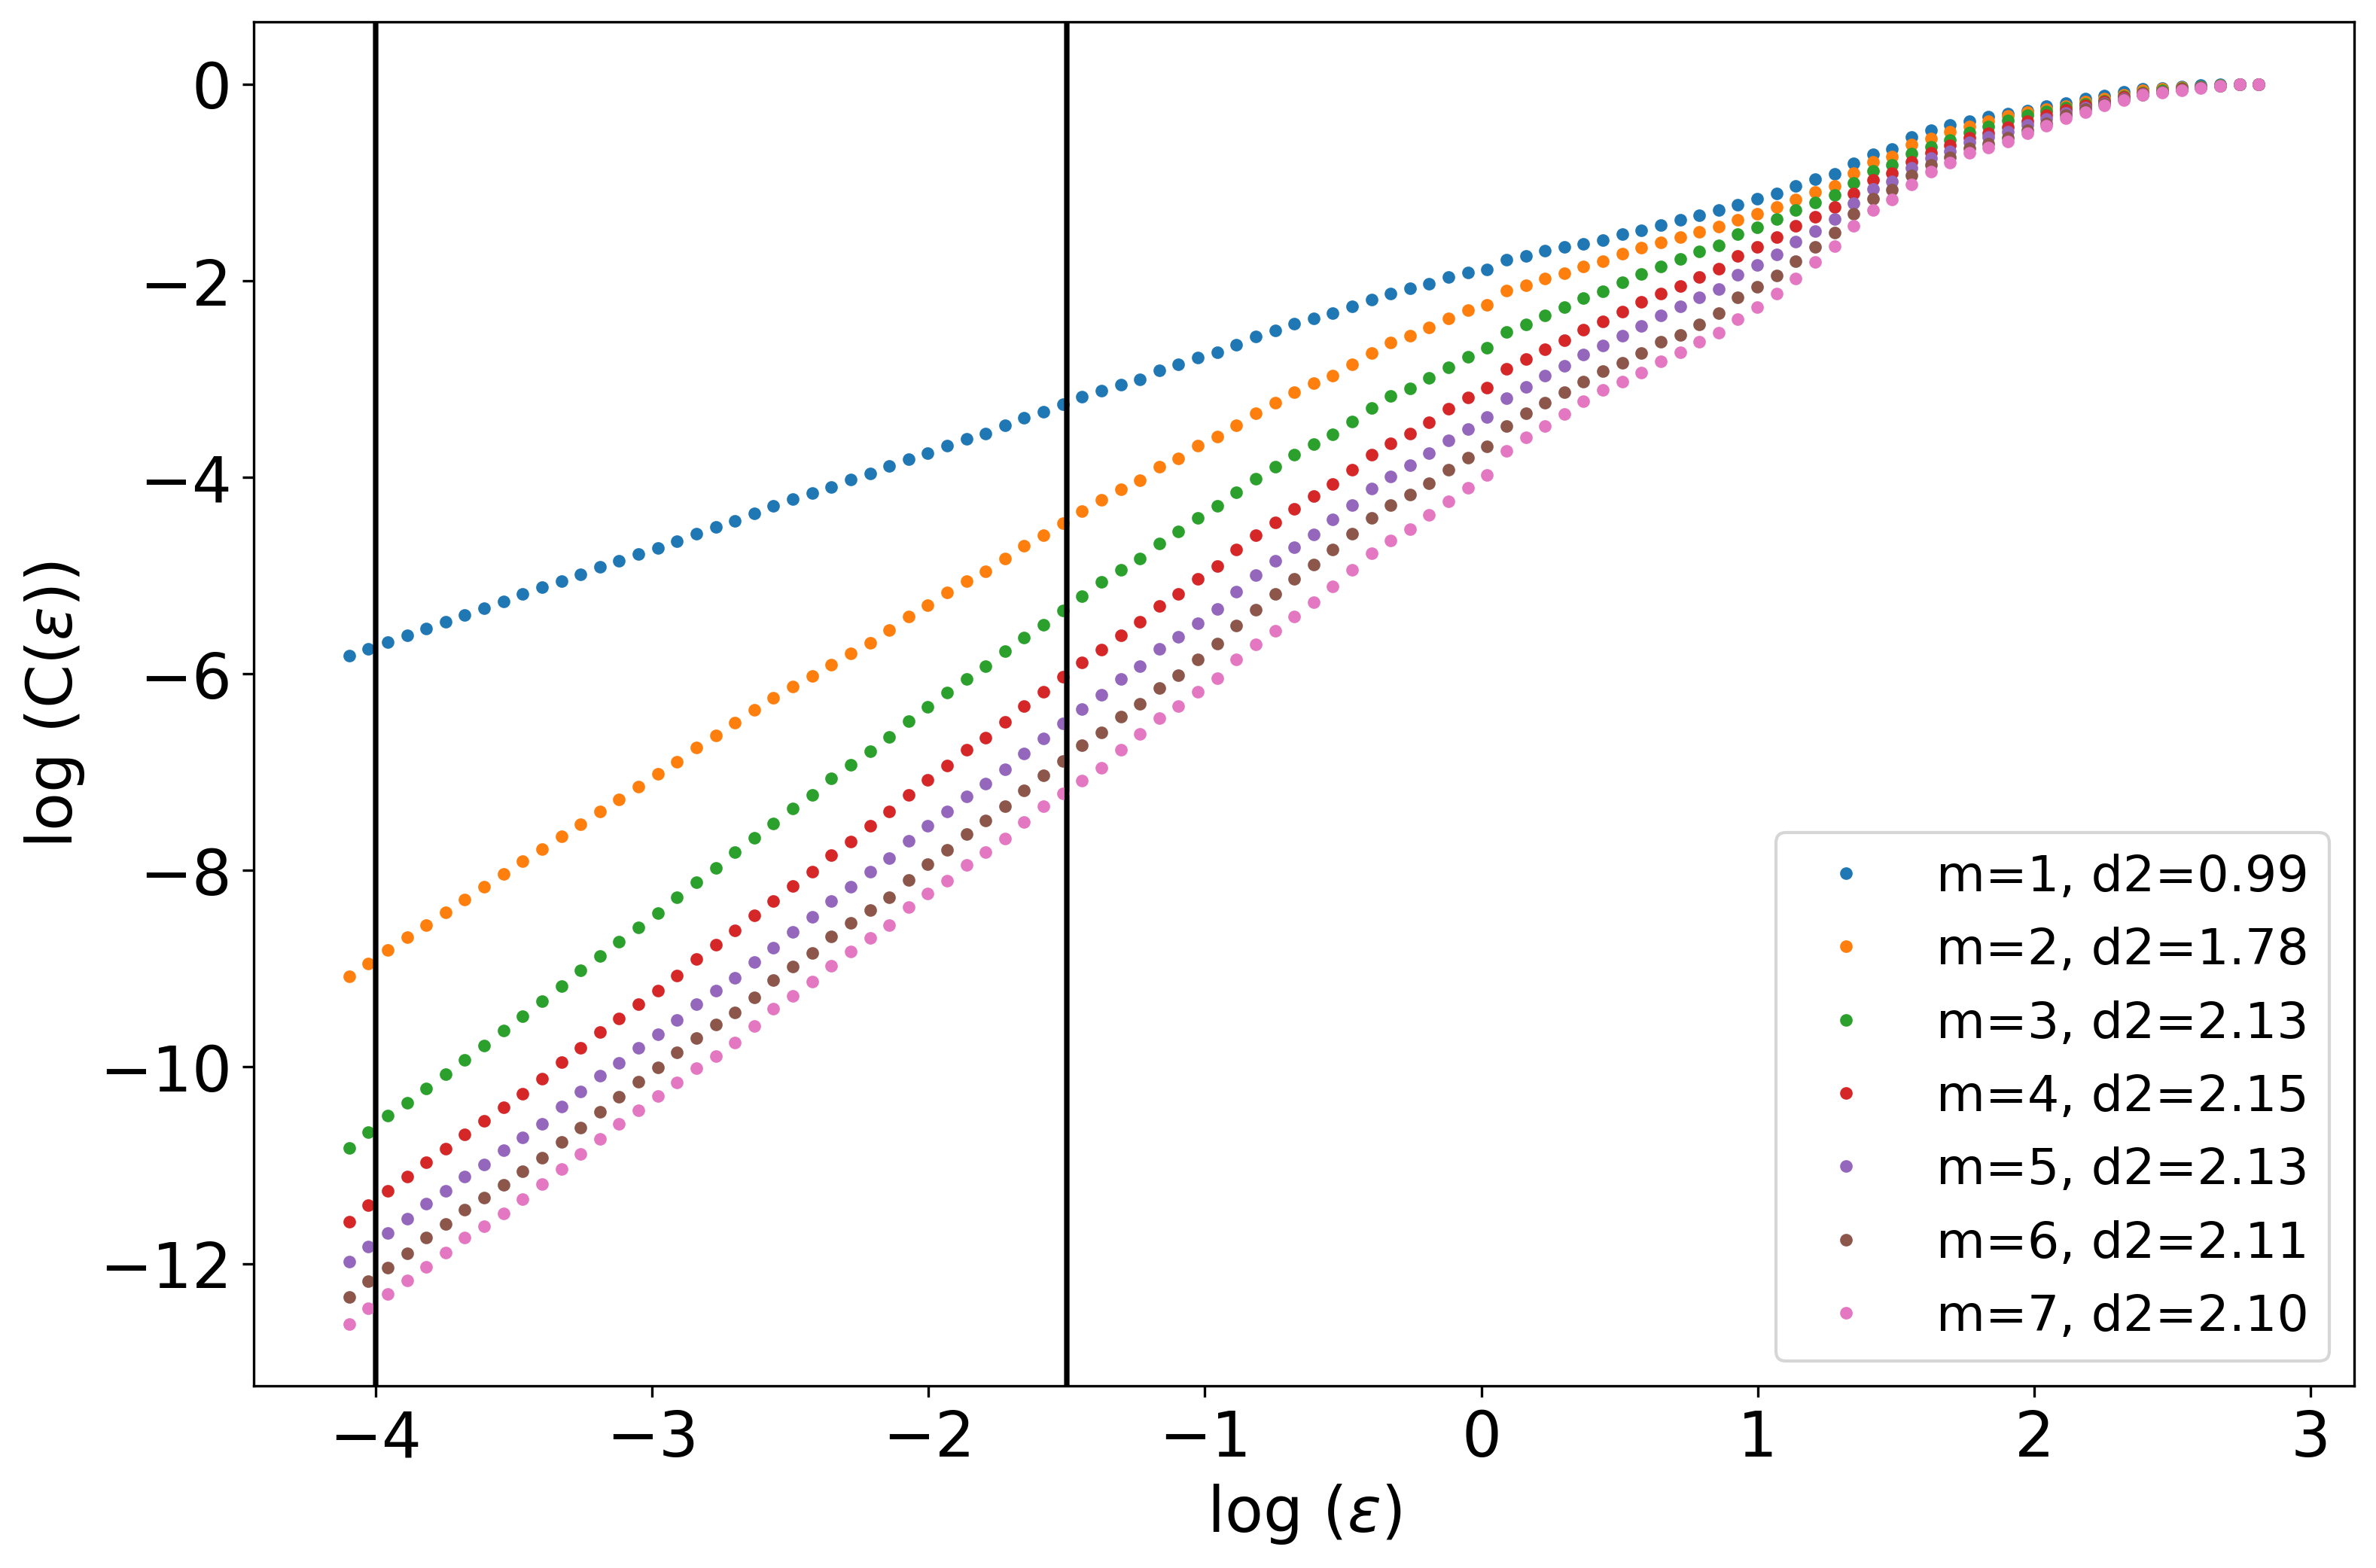

[-4, -1.5]
embedding dim=1, correlation dimension=0.9864613010183299+/-0.001042780252069263
embedding dim=2, correlation dimension=1.7795757283135762+/-0.00584838417796819
embedding dim=3, correlation dimension=2.126067412060565+/-0.004026958660629231
embedding dim=4, correlation dimension=2.1506161791234715+/-0.003903475622097575
embedding dim=5, correlation dimension=2.1300903278859136+/-0.004928086714430784
embedding dim=6, correlation dimension=2.111457058800131+/-0.004406521538535838
embedding dim=7, correlation dimension=2.0954150700373138+/-0.0038866553492021725


In [88]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]
tau=16
#limits = [-1.5,1.5]
#limits = [-3,-.5]
limits = [-4,-1.5]
#limits = [-1,1]
#series = data_lorenz(0,n=n,tmax=trans)

#plt.figure()
#plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('lorenz_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', theiler_window, data=lorenzTS, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_curvature_tau_{}_filtering_{}_limits_{}_{}.png'.format(tau, filter, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

# Lorenz tau = 60 (Mutual)



100
Additional non-data files were created
Saving as  d2_figures_paper/lorenz_mutual_tau_250_filtering_250_limits_-2_0.png


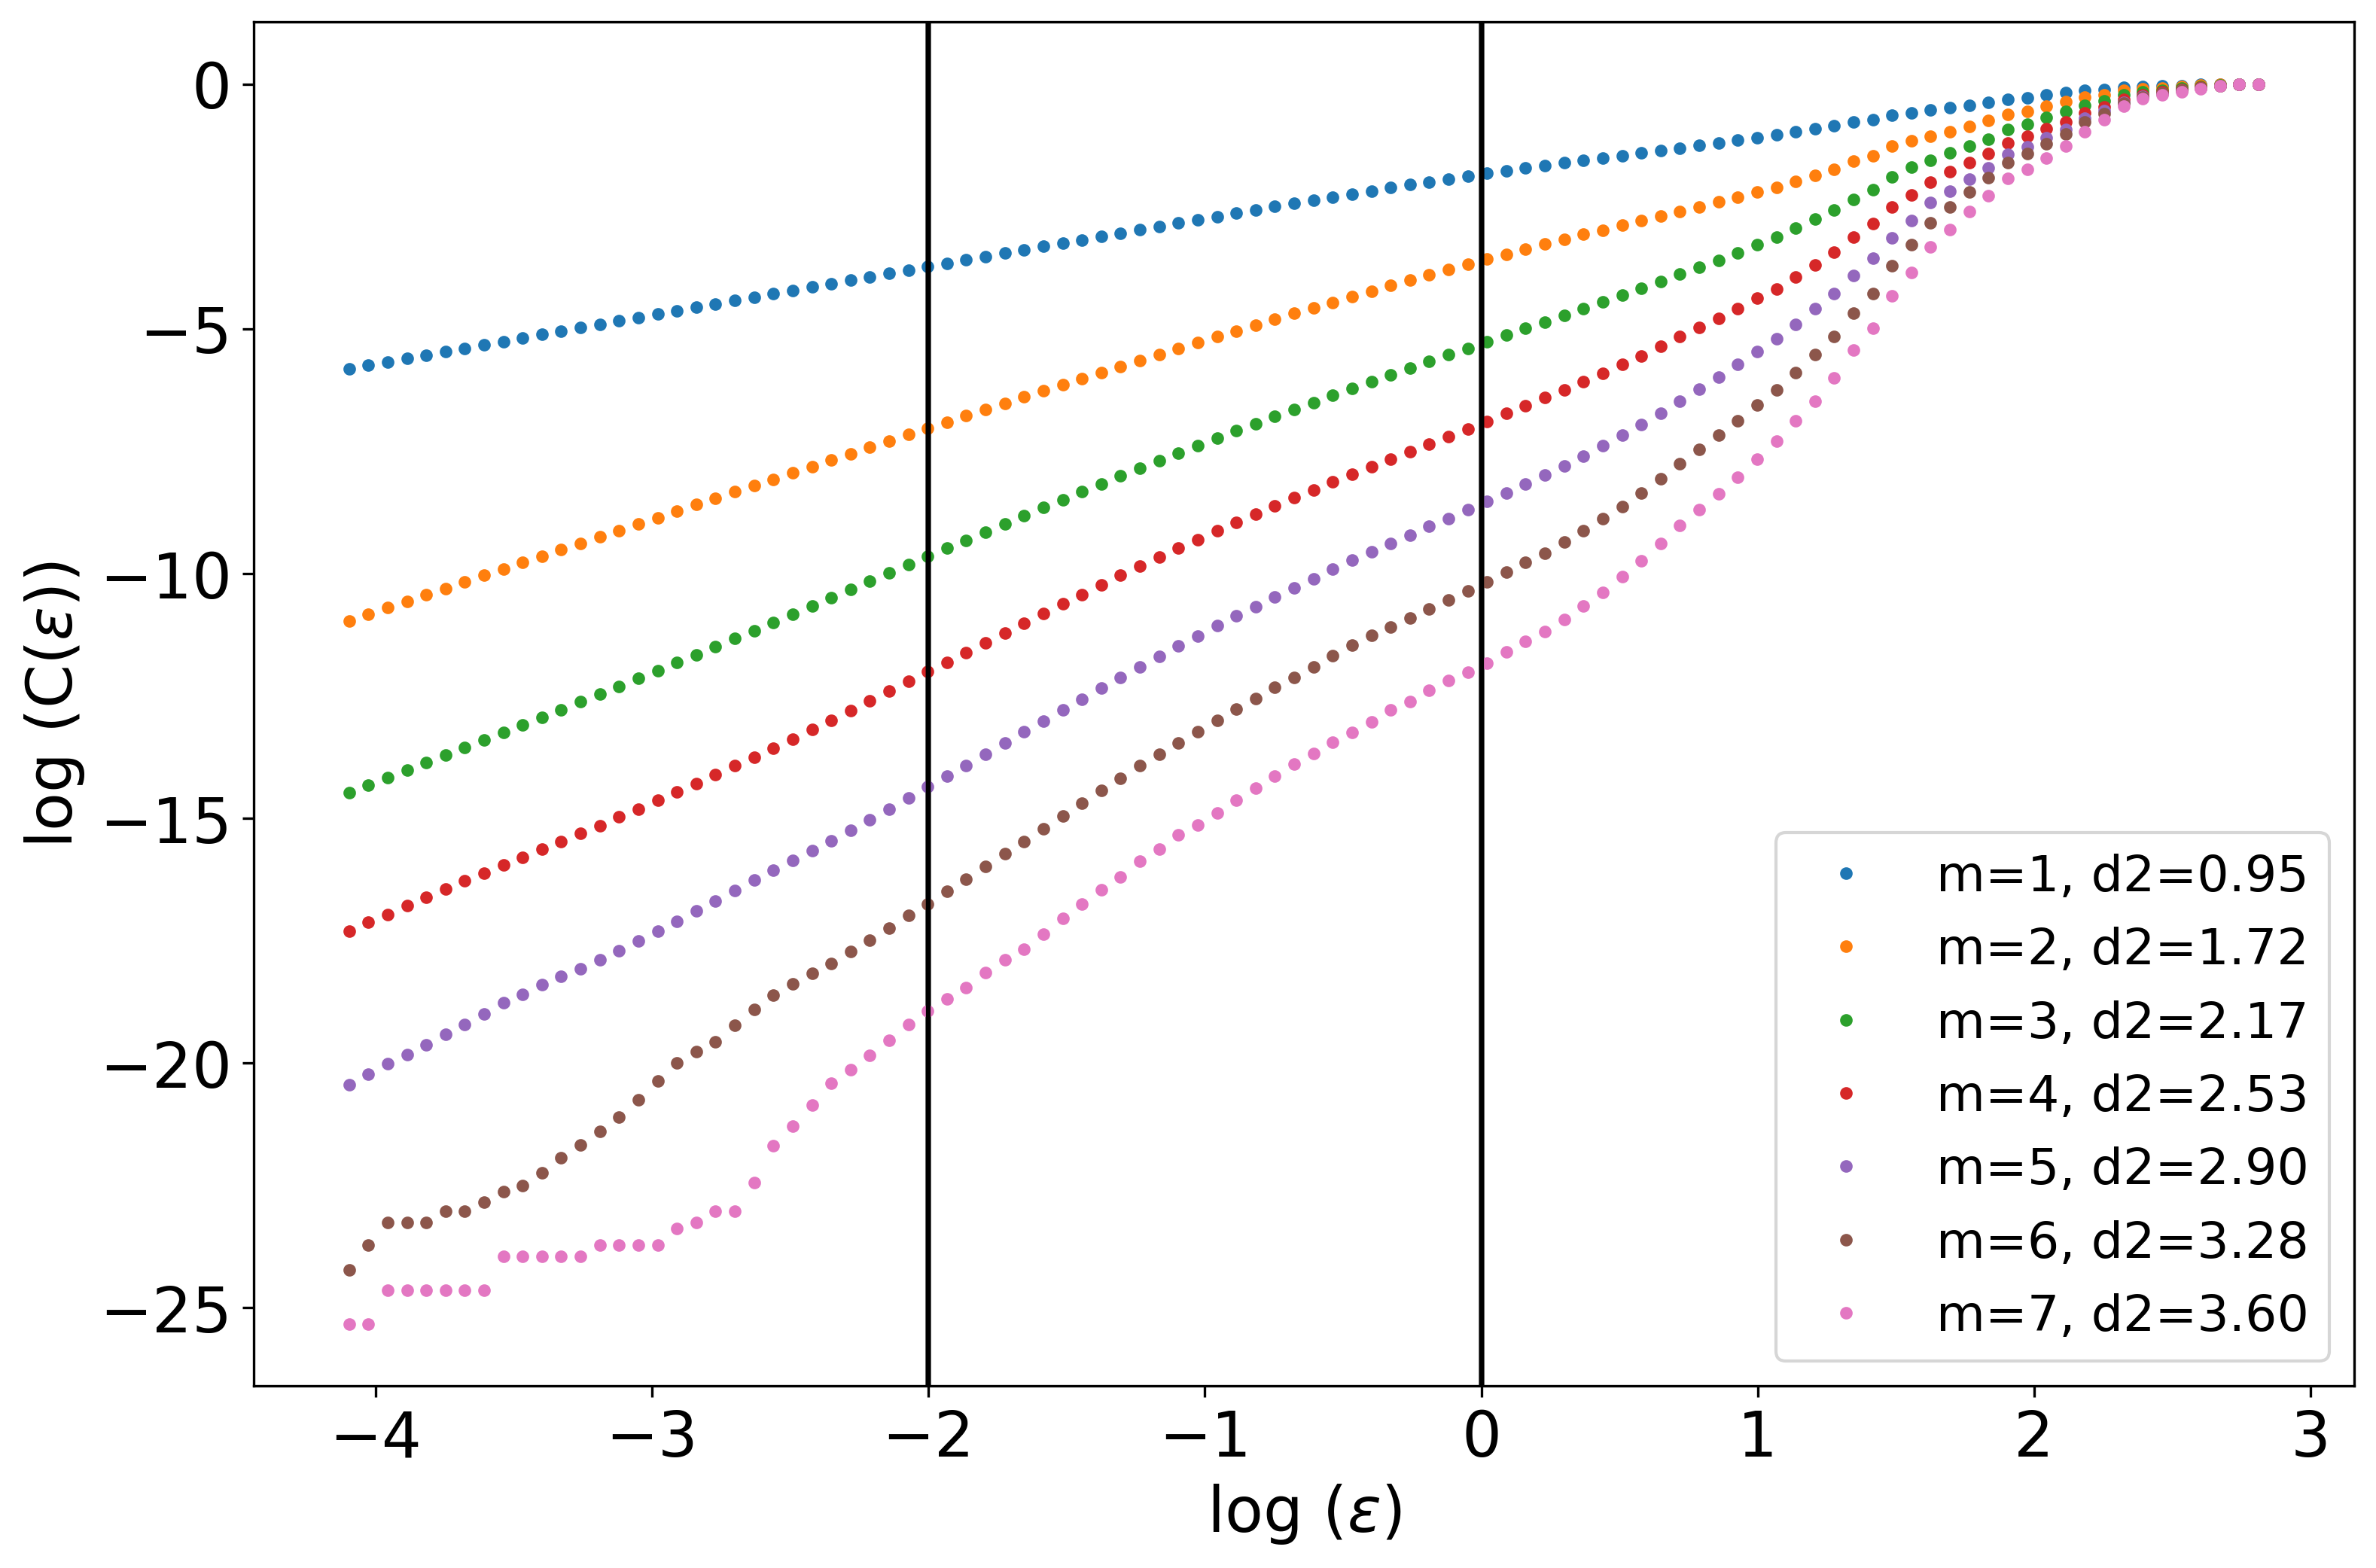

[-2, 0]
embedding dim=1, correlation dimension=0.9523281223256432+/-0.00364791970149853
embedding dim=2, correlation dimension=1.7169920159661278+/-0.007465932366556904
embedding dim=3, correlation dimension=2.1687601721856513+/-0.01542808911436941
embedding dim=4, correlation dimension=2.5255289099684943+/-0.02418474583955024
embedding dim=5, correlation dimension=2.901614262717827+/-0.028534863154523936
embedding dim=6, correlation dimension=3.2847203944240406+/-0.03678017981518077
embedding dim=7, correlation dimension=3.604445175538753+/-0.043545678907208785


In [91]:
tau = 250
dims = 7

#limits=[-1,1.5]
limits = [-2, 0]
#limits = [-4, -2]

#plt.figure(dpi=300)
#plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('lorenz_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_mutual_tau_{}_filtering_{}_limits_{}_{}.png'.format(tau, filter, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

738
Additional non-data files were created


/home/varad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Saving as  d2_figures_paper/corr/lorenz_mutual_tau_500_filtering_120_limits_0_2.png


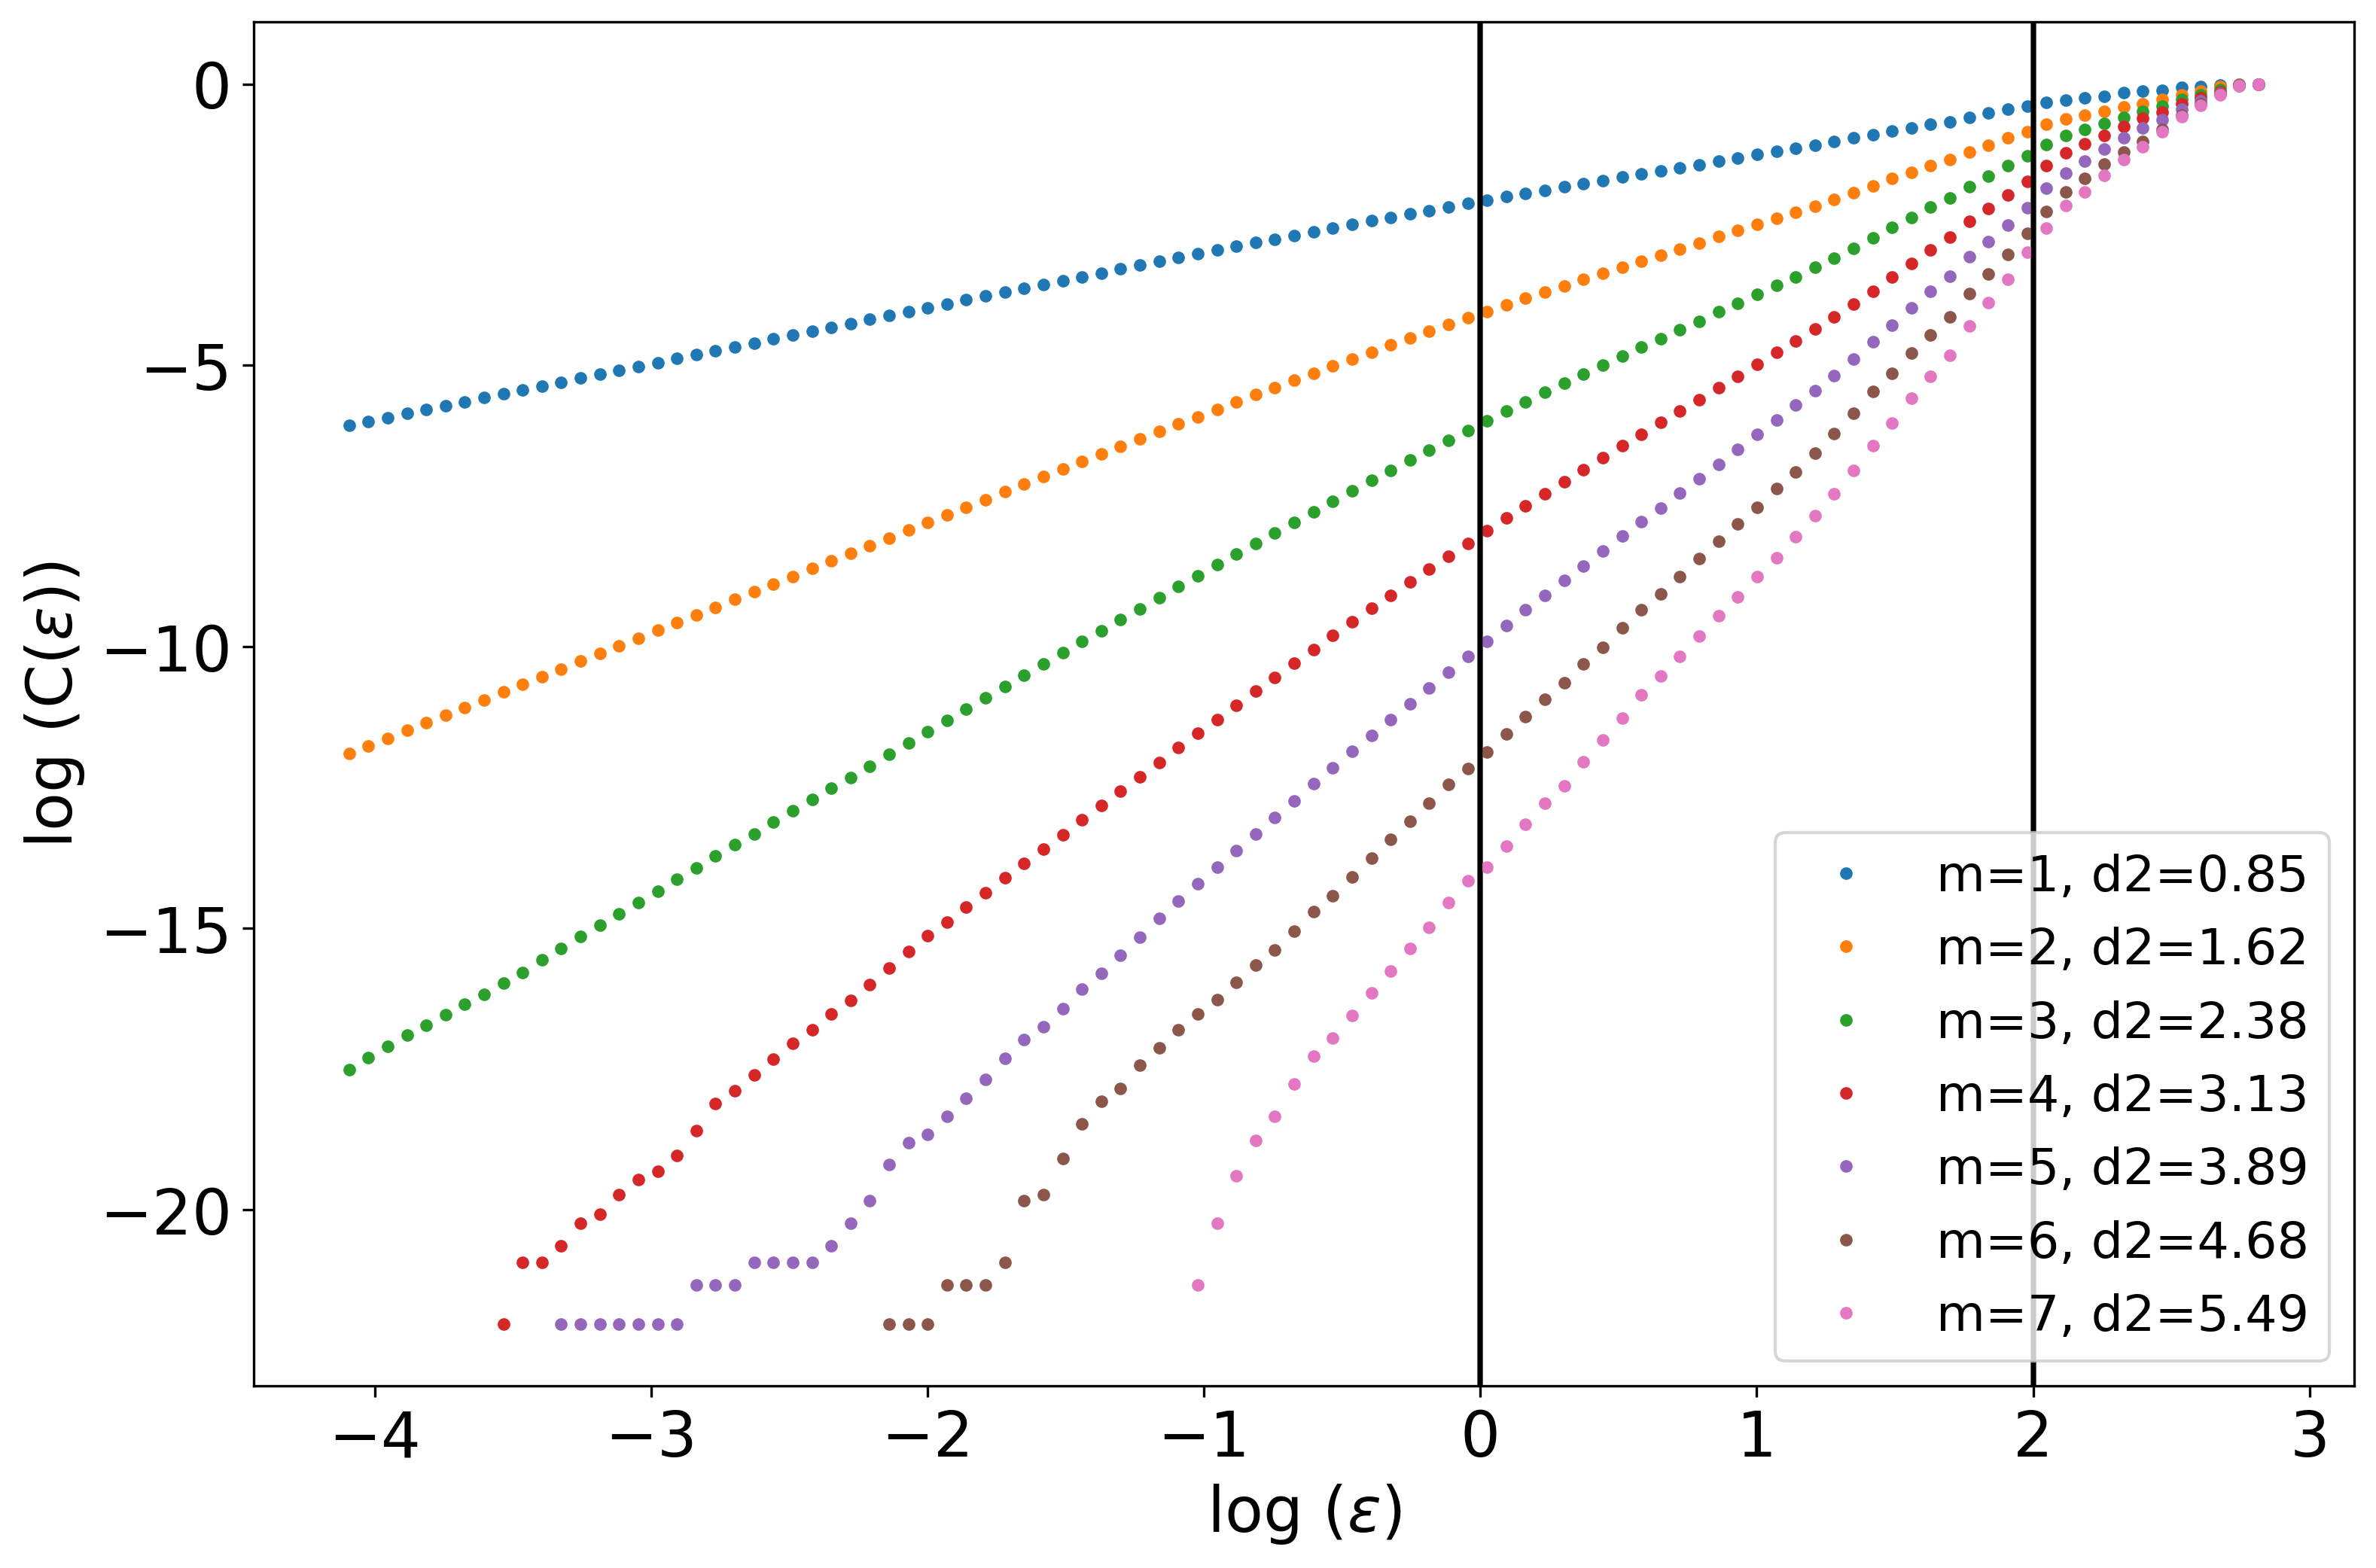

[0, 2]
embedding dim=1, correlation dimension=0.8464562873666172+/-0.004277375628471356
embedding dim=2, correlation dimension=1.6200522596628624+/-0.007117324738237454
embedding dim=3, correlation dimension=2.376634302271065+/-0.014221813312067105
embedding dim=4, correlation dimension=3.131093676014352+/-0.020017602731398014
embedding dim=5, correlation dimension=3.8945156305646895+/-0.022921539877882063
embedding dim=6, correlation dimension=4.680199427662231+/-0.027504520571492417
embedding dim=7, correlation dimension=5.492027860180302+/-0.03743460745909781


In [18]:
tau = 500
dims = 7

#limits=[-1,1.5]
limits = [0, 2]
#limits = [-4, -2]

#plt.figure(dpi=300)
#plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('lorenz_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/corr/lorenz_mutual_tau_{}_filtering_{}_limits_{}_{}.png'.format(tau, filter, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

Saving as  d2_figures_paper/lorenz_mutual_tau_250_filtering_250_limits_-1_0.png


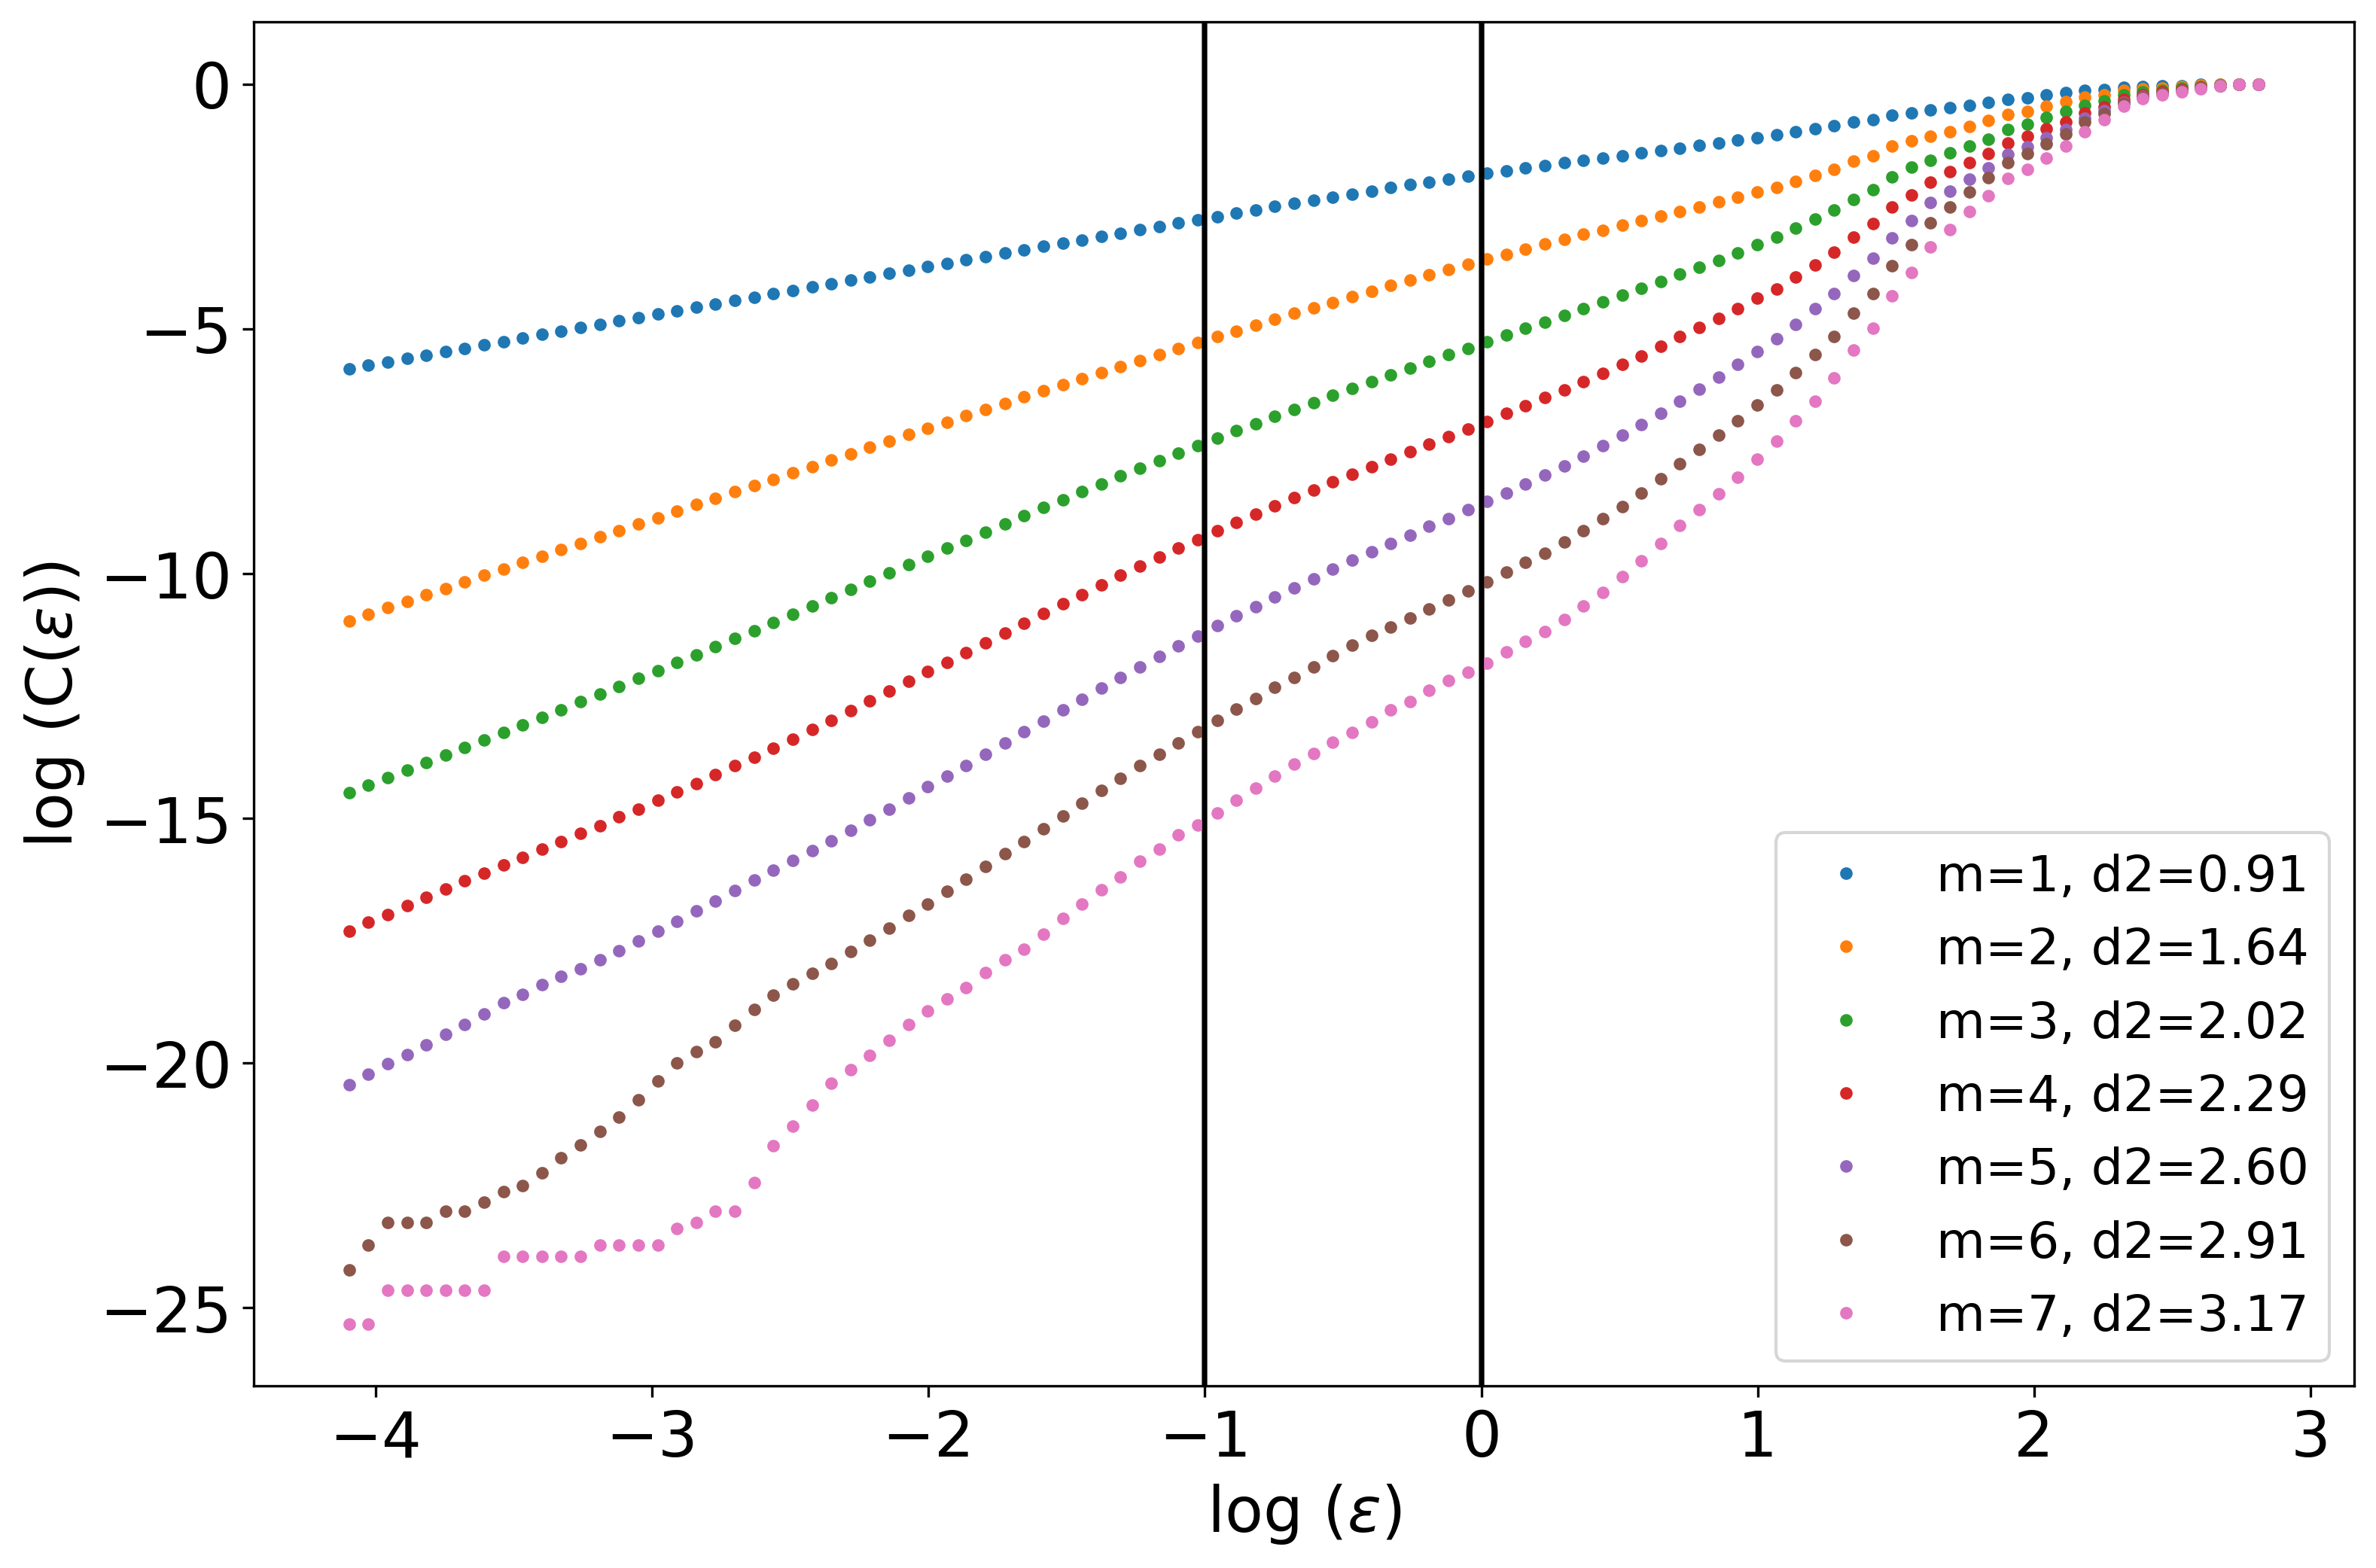

[-1, 0]
embedding dim=1, correlation dimension=0.9094579477340592+/-0.00532908043621151
embedding dim=2, correlation dimension=1.637279215667444+/-0.007843233417384505
embedding dim=3, correlation dimension=2.01597932362973+/-0.009532520295091992
embedding dim=4, correlation dimension=2.287920920322621+/-0.012878047032118657
embedding dim=5, correlation dimension=2.604247322289889+/-0.02112290597262747
embedding dim=6, correlation dimension=2.9092953906432517+/-0.03522759063328754
embedding dim=7, correlation dimension=3.1683522945532805+/-0.03797118156959364


In [93]:
limits = [-1, 0]
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_mutual_tau_{}_filtering_{}_limits_{}_{}.png'.format(tau, filter, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

In [ ]:
fnn_curvature, err = tiseanio('false_nearest', '-D', '18', '-m', '1', '-M', '1,10', '-t', 100, data=lorenzTS, silent=True)
fnn_ami, err = tiseanio('false_nearest', '-D', '160', '-m', '1', '-M', '1,10', '-t', 100, data=lorenzTS, silent=True)

In [ ]:
plt.plot(fnn_curvature[:,1])
plt.plot(fnn_ami[:,1])

In [ ]:
plt.plot(lorenzTS[:-18], lorenzTS[18:], '.' ,markersize=.1)
plt.plot(lorenzTS[:-60], lorenzTS[60:], '.' ,markersize=.1)